In [65]:
#Import dependencies for Google Drive mounting and TensorFlow/Keras framework.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as py
import datetime
import seaborn as sns
from google.colab import drive
from sklearn import preprocessing
py.offline.init_notebook_mode(connected=True)
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from keras.layers import Flatten
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import GlobalAveragePooling1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import LeakyReLU
from keras import optimizers
from keras.layers import Dense, Activation, Dropout
from keras.layers import AveragePooling1D
from keras.layers import TimeDistributed
from keras.layers import LSTM
from keras.layers import LSTM
from keras.layers import Reshape
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from matplotlib.pyplot import figure
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session
import gc

In [2]:
#Mount drive and read in CSV data from the /Data\ /Pipeline.ipynb ETL pipeline
drive.mount('/content/drive/')
aapl = pd.read_csv("/content/drive/My Drive/Stock Price Prediction Research/Data/aapl_prices_fiveminute_stats_wsh.csv")
aapl.head(5)

Mounted at /content/drive/


,Unnamed: 0,PRICE_MEAN,VOLUME_MEAN,PRICE_HIGH,PRICE_LOW,PRICE_OPEN,PRICE_CLOSE
0,1/2/2001 9:30,14.930692,565.354331,15.0000,14.8750,14.8750,14.8750
1,1/2/2001 9:35,14.936993,707.792208,15.0625,14.6875,14.8750,14.9375
2,1/2/2001 9:40,15.021382,944.939271,15.0625,14.9375,14.9375,15.0625
3,1/2/2001 9:45,15.114291,735.205992,15.2500,15.0000,15.0625,15.0625
4,1/2/2001 9:50,14.938517,1075.739645,15.0625,14.8125,15.0625,14.9375


In [3]:
#Split datetime objects into individual Day, Month, Year, Hour, and Minute features
date_time = pd.to_datetime(aapl['Unnamed: 0'], infer_datetime_format=True)
datetime_table = pd.DataFrame({'DAY':date_time.dt.day, 'MONTH':date_time.dt.month,'YEAR':date_time.dt.year,'HOUR': date_time.dt.hour, 'MINUTE': date_time.dt.minute})
aapl = aapl.join(datetime_table, how = 'outer')

In [4]:
aapl

,Unnamed: 0,PRICE_MEAN,VOLUME_MEAN,PRICE_HIGH,PRICE_LOW,PRICE_OPEN,PRICE_CLOSE,DAY,MONTH,YEAR,HOUR,MINUTE
0,1/2/2001 9:30,14.930692,565.354331,15.0000,14.8750,14.8750,14.8750,2,1,2001,9,30
1,1/2/2001 9:35,14.936993,707.792208,15.0625,14.6875,14.8750,14.9375,2,1,2001,9,35
2,1/2/2001 9:40,15.021382,944.939271,15.0625,14.9375,14.9375,15.0625,2,1,2001,9,40
3,1/2/2001 9:45,15.114291,735.205992,15.2500,15.0000,15.0625,15.0625,2,1,2001,9,45
4,1/2/2001 9:50,14.938517,1075.739645,15.0625,14.8125,15.0625,14.9375,2,1,2001,9,50
...,...,...,...,...,...,...,...,...,...,...,...,...
198227,12/31/2010 15:40,322.018105,189.182561,322.0600,321.9500,322.0000,321.9800,31,12,2010,15,40
198228,12/31/2010 15:45,321.553314,201.234844,321.9800,321.3100,321.9500,321.4500,31,12,2010,15,45
198229,12/31/2010 15:50,321.785672,151.116947,322.1100,321.4400,321.4500,322.0580,31,12,2010,15,50
198230,12/31/2010 15:55,322.360772,225.504791,322.7000,322.0100,322.0300,322.6500,31,12,2010,15,55


In [5]:
def stocksplit(stock,day, month, year, ratio):
  #This function takes a specific date on which a stock split occurs for a stock and changes the price and volume to the pre-split price for consistent data for the model

  date_index = stock.loc[(stock['YEAR'] == year) & (stock['DAY'] == day) & (stock['MONTH']==month)].index.values.astype(int)[0]
  pre_split_high  = stock.iloc[:date_index]['PRICE_HIGH']
  pre_split_low = stock.iloc[:date_index]['PRICE_LOW']
  pre_split_open = stock.iloc[:date_index]['PRICE_OPEN']
  pre_split_close = stock.iloc[:date_index]['PRICE_CLOSE']
  pre_split_mean = stock.iloc[:date_index]['PRICE_MEAN']
  pre_split_volume = stock.iloc[:date_index]['VOLUME_MEAN']

  print(pre_split_volume)
  post_split_high  = stock.iloc[date_index:]['PRICE_HIGH']
  post_split_low = stock.iloc[date_index:]['PRICE_LOW']
  post_split_open = stock.iloc[date_index:]['PRICE_OPEN']
  post_split_close = stock.iloc[date_index:]['PRICE_CLOSE']
  post_split_mean = stock.iloc[date_index:]['PRICE_MEAN']
  post_split_volume = stock.iloc[date_index:]['VOLUME_MEAN']
  print(post_split_volume)
  post_split_high  = post_split_high*ratio
  post_split_low = post_split_low*ratio
  post_split_open = post_split_open*ratio
  post_split_close = post_split_close*ratio
  post_split_mean = post_split_mean*ratio
  post_split_volume = post_split_volume/ratio
  
  print(post_split_volume)
  
  price_high  = pre_split_high.append(post_split_high)
  price_low = pre_split_low.append(post_split_low)
  price_open = pre_split_open.append(post_split_open)
  price_close = pre_split_close.append(post_split_close)
  price_mean = pre_split_mean.append(post_split_mean)
  volume = pre_split_volume.append(post_split_volume)
  stock["PRICE_HIGH"] = price_high
  stock["PRICE_LOW"] = price_low
  stock["PRICE_OPEN"] = price_open
  stock["PRICE_CLOSE"] = price_close
  stock["PRICE_MEAN"] = price_mean
  stock["VOLUME_MEAN"] = volume
  return stock

In [6]:
#Un-split the stock on Feb. 28, 2005 from a two way split.
aapl = stocksplit(aapl, 28, 2, 2005, 2)
aapl

0         565.354331
1         707.792208
2         944.939271
3         735.205992
4        1075.739645
            ...     
81972     272.685892
81973     311.289003
81974     276.734310
81975     304.983713
81976    1514.884615
Name: VOLUME_MEAN, Length: 81977, dtype: float64
81977       310.774035
81978       260.109650
81979       266.699053
81980       249.828864
81981       278.068268
              ...     
198227      189.182561
198228      201.234844
198229      151.116947
198230      225.504791
198231    14462.520000
Name: VOLUME_MEAN, Length: 116255, dtype: float64
81977      155.387018
81978      130.054825
81979      133.349527
81980      124.914432
81981      139.034134
             ...     
198227      94.591281
198228     100.617422
198229      75.558473
198230     112.752395
198231    7231.260000
Name: VOLUME_MEAN, Length: 116255, dtype: float64


,Unnamed: 0,PRICE_MEAN,VOLUME_MEAN,PRICE_HIGH,PRICE_LOW,PRICE_OPEN,PRICE_CLOSE,DAY,MONTH,YEAR,HOUR,MINUTE
0,1/2/2001 9:30,14.930692,565.354331,15.0000,14.8750,14.8750,14.8750,2,1,2001,9,30
1,1/2/2001 9:35,14.936993,707.792208,15.0625,14.6875,14.8750,14.9375,2,1,2001,9,35
2,1/2/2001 9:40,15.021382,944.939271,15.0625,14.9375,14.9375,15.0625,2,1,2001,9,40
3,1/2/2001 9:45,15.114291,735.205992,15.2500,15.0000,15.0625,15.0625,2,1,2001,9,45
4,1/2/2001 9:50,14.938517,1075.739645,15.0625,14.8125,15.0625,14.9375,2,1,2001,9,50
...,...,...,...,...,...,...,...,...,...,...,...,...
198227,12/31/2010 15:40,644.036210,94.591281,644.1200,643.9000,644.0000,643.9600,31,12,2010,15,40
198228,12/31/2010 15:45,643.106627,100.617422,643.9600,642.6200,643.9000,642.9000,31,12,2010,15,45
198229,12/31/2010 15:50,643.571344,75.558473,644.2200,642.8800,642.9000,644.1160,31,12,2010,15,50
198230,12/31/2010 15:55,644.721545,112.752395,645.4000,644.0200,644.0600,645.3000,31,12,2010,15,55


# **FEATURE** **ENGINEERING**


In [7]:
def diff(df, col):
  #This function differences the Pandas DataFrame for the specific column and 
  #appends it to the end of the DataFrame.
  orig_df = df.copy()
  difference = pd.DataFrame({'DIFF_'+col:np.diff(df[col])})
  orig_df = orig_df.join(difference, how = 'outer')
  return orig_df
  

In [8]:
aapl_diff = diff(aapl, 'PRICE_OPEN')
aapl_diff = diff(aapl_diff, 'PRICE_CLOSE')
aapl_diff = diff(aapl_diff, 'PRICE_HIGH')
aapl_diff = diff(aapl_diff, 'PRICE_LOW')
aapl_diff = diff(aapl_diff, 'PRICE_MEAN')
aapl_diff = diff(aapl_diff, 'VOLUME_MEAN')



In [9]:

def perc_change(df, col):
  #This function gives the percentage change of the difference column inputted 
  #and appends it to the end of the DataFrame.
  original = df.loc[:,col]
  difference = df.loc[:, 'DIFF_'+ col]
  percentage = difference/original
  perc_df = pd.DataFrame({'PERC_'+col: percentage})
  df = df.join(perc_df, how = 'outer')
  return df


In [10]:
aapl_diff = perc_change(aapl_diff, 'PRICE_OPEN')
aapl_diff = perc_change(aapl_diff, 'PRICE_CLOSE')

In [11]:
def range_func(df):
  #Appends the range of the price of the stock in the 5 minutes to the end of the DataFrame.
  high = df.PRICE_HIGH
  low = df.PRICE_LOW
  hl_range = high-low 
  difference = np.diff(hl_range)
  diff = pd.DataFrame({'RANGE':difference})
  df=df.join(diff, how= 'outer')
  return df

In [12]:
aapl_diff = range_func(aapl_diff)

In [13]:
def time_of_day(df):
  #Codifies time of day to reduce the cardinality of 8 the day-trade hours to
  #3 variables: Morning, Afternoon, and Evening
  orig_df = df.copy()
  hour = orig_df.HOUR 
  part_of_day = [1 if x < 11 else 2 if x<13 else 3 for x in hour]
  part_of_day = pd.DataFrame({'TIME':part_of_day})
  orig_df = orig_df.join(part_of_day,how = 'outer')
  return orig_df

In [14]:
aapl_diff = time_of_day(aapl_diff)

In [15]:
time_of_day = pd.get_dummies(aapl_diff.TIME)
time_of_day = time_of_day.rename(columns={1:'MORNING',2:'AFTERNOON', 3:'EVENING'})
aapl_diff = aapl_diff.join(time_of_day, how = 'outer')

In [16]:
def day_of_week(df):
  #Creates a new day of week feature from the existing date columns from the DataFrame.
  orig_df = df.copy()
  date = [datetime.date(y,m,d) for y,m,d in zip(orig_df.YEAR, orig_df.MONTH, orig_df.DAY)]
  part_of_week = [x.weekday() for x in date]
  part_of_week = pd.DataFrame({'DAY_OF_WEEK': part_of_week})
  orig_df = orig_df.join(part_of_week, how = 'outer')
  return orig_df

In [17]:
aapl_diff = day_of_week(aapl_diff)

In [18]:
#One Hot Encode the days of the week variables
day_of_week = pd.get_dummies(aapl_diff.DAY_OF_WEEK)
day_of_week = day_of_week.rename(columns={0:'MON',1:'TUE', 2:'WED',3:'THUR',4:'FRI'})
aapl_diff = aapl_diff.join(day_of_week, how = 'outer')

In [19]:
def movement(df):
  #Creates a new price movement Y-variable based on the sign of the difference for each row of the 
  #stock data.
  orig_df = df.copy()
  movement= [0 if x< 0 else 1 for x in orig_df['DIFF_PRICE_OPEN']]
  movement = pd.DataFrame({'MOVEMENT': movement})
  
  return movement

    

In [20]:
def n_timesteps(df, n, feature):
  #This function creates n lags of the data to create n timesteps for each feature.
  feature_df = df[[feature]]
  #temp = (feature_df - feature_df.min()) /(feature_df.max()-feature_df.min())
  temp = feature_df
  for i in range(1,n+1):
    shifted  = temp.shift(i).loc[:,feature]
    feature_df = feature_df.join(shifted, how = 'outer', rsuffix = i)

  return feature_df[n:-1]


In [21]:
n = 4
df_open = n_timesteps(aapl_diff, n,'DIFF_PRICE_OPEN')
df_close = n_timesteps(aapl_diff,n, 'DIFF_PRICE_CLOSE')
df_high = n_timesteps(aapl_diff,n, 'DIFF_PRICE_HIGH')
df_low = n_timesteps(aapl_diff,n, 'DIFF_PRICE_LOW')
df_mean = n_timesteps(aapl_diff,n, 'DIFF_PRICE_MEAN')
df_vol = n_timesteps(aapl_diff,n, 'DIFF_VOLUME_MEAN')
df_open_perc = n_timesteps(aapl_diff, n, 'PERC_PRICE_OPEN')
df_close_perc = n_timesteps(aapl_diff, n, 'PERC_PRICE_CLOSE')
df_morning = n_timesteps(aapl_diff,n, 'MORNING')
df_afternoon = n_timesteps(aapl_diff, n, 'AFTERNOON')
df_evening = n_timesteps(aapl_diff, n, 'EVENING')
df_mon = n_timesteps(aapl_diff,n, 'MON')
df_tue = n_timesteps(aapl_diff,n, 'TUE')
df_wed = n_timesteps(aapl_diff,n, 'WED')
df_thur = n_timesteps(aapl_diff,n, 'THUR')
df_fri = n_timesteps(aapl_diff,n, 'FRI')
df_range = n_timesteps(aapl_diff, n,'RANGE')
df_month = n_timesteps(aapl_diff, n, 'MONTH')
df_day = n_timesteps(aapl_diff,n,'DAY')
aapl_diff.head(5)

,Unnamed: 0,PRICE_MEAN,VOLUME_MEAN,PRICE_HIGH,PRICE_LOW,PRICE_OPEN,PRICE_CLOSE,DAY,MONTH,YEAR,HOUR,MINUTE,DIFF_PRICE_OPEN,DIFF_PRICE_CLOSE,DIFF_PRICE_HIGH,DIFF_PRICE_LOW,DIFF_PRICE_MEAN,DIFF_VOLUME_MEAN,PERC_PRICE_OPEN,PERC_PRICE_CLOSE,RANGE,TIME,MORNING,AFTERNOON,EVENING,DAY_OF_WEEK,MON,TUE,WED,THUR,FRI
0,1/2/2001 9:30,14.930692,565.354331,15.0000,14.8750,14.8750,14.8750,2,1,2001,9,30,0.0000,0.0625,0.0625,-0.1875,0.006300,142.437877,0.000000,0.004202,0.2500,1,1,0,0,1,0,1,0,0,0
1,1/2/2001 9:35,14.936993,707.792208,15.0625,14.6875,14.8750,14.9375,2,1,2001,9,35,0.0625,0.1250,0.0000,0.2500,0.084389,237.147063,0.004202,0.008368,-0.2500,1,1,0,0,1,0,1,0,0,0
2,1/2/2001 9:40,15.021382,944.939271,15.0625,14.9375,14.9375,15.0625,2,1,2001,9,40,0.1250,0.0000,0.1875,0.0625,0.092909,-209.733279,0.008368,0.000000,0.1250,1,1,0,0,1,0,1,0,0,0
3,1/2/2001 9:45,15.114291,735.205992,15.2500,15.0000,15.0625,15.0625,2,1,2001,9,45,0.0000,-0.1250,-0.1875,-0.1875,-0.175774,340.533652,0.000000,-0.008299,0.0000,1,1,0,0,1,0,1,0,0,0
4,1/2/2001 9:50,14.938517,1075.739645,15.0625,14.8125,15.0625,14.9375,2,1,2001,9,50,-0.1875,-0.1250,-0.1250,-0.0625,-0.104371,-599.592856,-0.012448,-0.008368,-0.0625,1,1,0,0,1,0,1,0,0,0


In [22]:
df_open

,DIFF_PRICE_OPEN,DIFF_PRICE_OPEN1,DIFF_PRICE_OPEN2,DIFF_PRICE_OPEN3,DIFF_PRICE_OPEN4
4,-0.18750,0.0000,0.1250,0.0625,0.0000
5,-0.12500,-0.1875,0.0000,0.1250,0.0625
6,0.06250,-0.1250,-0.1875,0.0000,0.1250
7,-0.06250,0.0625,-0.1250,-0.1875,0.0000
8,0.03125,-0.0625,0.0625,-0.1250,-0.1875
...,...,...,...,...,...
198226,0.10000,-0.0400,-0.1600,-0.0800,-0.1600
198227,-0.10000,0.1000,-0.0400,-0.1600,-0.0800
198228,-1.00000,-0.1000,0.1000,-0.0400,-0.1600
198229,1.16000,-1.0000,-0.1000,0.1000,-0.0400


In [23]:
#This cell converts all DataFrames with n lags into numpy arrays.


array_open = df_open.iloc[:, 1:].to_numpy()
array_close = df_close.iloc[:, 1:].to_numpy()
array_high = df_high.iloc[:, 1:].to_numpy()
array_low =df_low.iloc[:, 1:].to_numpy()
array_mean = df_mean.iloc[:, 1:].to_numpy()
array_vol = df_vol.iloc[:, 1:].to_numpy()
array_open_perc = df_open_perc.iloc[:, 1:].to_numpy()
array_close_perc = df_close_perc.iloc[:, 1:].to_numpy()
array_morning = df_morning.iloc[:, 1:].to_numpy()
array_afternoon =df_afternoon.iloc[:, 1:].to_numpy()
array_evening = df_evening.iloc[:, 1:].to_numpy()
array_mon = df_mon.iloc[:, 1:].to_numpy()
array_tue = df_tue.iloc[:, 1:].to_numpy()
array_wed = df_wed.iloc[:, 1:].to_numpy()
array_thur = df_thur.iloc[:, 1:].to_numpy()
array_fri = df_fri.iloc[:, 1:].to_numpy()
array_range = df_range.iloc[:, 1:].to_numpy()
array_month = df_month.iloc[:, 1:].to_numpy()
array_day = df_day.iloc[:, 1:].to_numpy()

In [24]:
#Stacks all the lagged features to a single DataFrame.
x_val = np.stack((array_open, array_close,array_high, array_low, array_mean, array_vol, array_open_perc, array_close_perc, array_mon,array_tue,array_wed,array_thur,array_fri,array_morning,array_afternoon, array_evening, array_range, array_month,array_day), axis=1)

In [25]:
#Uses the price movement as the Y target variable
y_val = movement(df_open[['DIFF_PRICE_OPEN']]).to_numpy()
y_val[:10]

array([[0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1]])

In [26]:
#Clear the variables to save memory
array_open = 0
array_close = 0
array_high = 0
array_low =0
array_mean = 0
array_vol = 0
array_open_perc = 0
array_close_perc = 0
array_time_of_day = 0
array_day_of_week = 0
array_range =0
array_month = 0
array_day = 0

df_open = 0
df_close = 0
df_high = 0
df_low = 0
df_mean = 0
df_vol =0
df_open_perc = 0
df_close_perc = 0
df_time_of_day =0
df_day_of_week = 0
df_range = 0
df_month = 0
df_day = 0

In [27]:
gc.collect()

11

# RNN Architecture

In [31]:
from keras import metrics

In [60]:
def evaluate_model(trainX, trainy, testX, testy, batch_size, epochs,verbose, model_weights = None):
    # Trains a recurrent neural network with the training and testing data sets inputted, 
    # with specified batch size, number of epochs, and saved model weights (if inputted).
    verbose, epochs, batch_size = verbose, epochs, batch_size
    n_timesteps, n_features, n_outputs = 4, 1, 1

    #trainX = trainX.reshape(trainX.shape[0], trainX.shape[1],1)
    #testX = testX.reshape(testX.shape[0], testX.shape[1],1)
    
    model = Sequential()
    model.add(LSTM(40, stateful = True, return_sequences=True,batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2])))
    
    
    #model.add(Conv1D( filters = 3, kernel_size = 1, activation='relu'))
    #model.add(Reshape((1,1,80,1)))
    #model.add(TimeDistributed(AveragePooling1D()))
    #model.add(TimeDistributed(Conv1D(100, 10, activation='relu')))
    #model.add(TimeDistributed(Flatten()))
    #model.add(LSTM(60, stateful = True, return_sequences=True,batch_input_shape = (batch_size, trainX.shape[1], trainX.shape[2])))
    model.add(LSTM(120, stateful = True, return_sequences=True))
    model.add(LSTM(120, stateful = True, return_sequences=True))
    model.add(LSTM(40, stateful = True))
    #model.add(Dropout(0.4))
    model.add(Dense(50, activation='relu'))
    
    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))
    #opt = optimizers.adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.001, amsgrad=False)

            
    if model_weights == True:
      model.load_weights("/content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5")
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.FalsePositives(),'accuracy',metrics.AUC()])
    else:
      model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[metrics.FalsePositives(),'accuracy',metrics.AUC()])
    # fit network
    filepath="/content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor=[metrics.FalsePositives(),'accuracy',metrics.AUC()], verbose=1, save_best_only=False, mode='max')
    callbacks_list = [checkpoint]

    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size,callbacks=callbacks_list, verbose=verbose, shuffle = False)
    # evaluate model"
    _, falsepositive, accuracy,auc = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    
    pred = model.predict(testX, batch_size = batch_size, verbose = 0)
    weights = True
    clear_session()
    
    return pred, weights,accuracy, falsepositive,auc

In [55]:
def walk_forward(initial_epochs, window, batch_size, wf_epochs, val_size):
  """ Uses the walk forward algorithm to validate the model using incremental learning.

      initial_epochs: The number of epochs used to train the model on the initial training window 
      denoted in window.

      window: The size of the number of data points used to train the model initially.

      batch_size: The number of data points that is used for batch gradient descent.

      wf_epochs: The number of training epochs used in the model when the model is introduced
      to new data through walk-forward validation. 

      val_size: The number of iterations done for walk-forward validation.

  """
  prediction_days = []
  actual_days = [] 
  walk_train = []
  walk_test = []

  x = x_val
  y = y_val
 
  multiplier = 2 **10
  initial_mult = 2 **12
  test_size =2**9
  accuracy_days = pd.DataFrame(columns=['Minute','Accuracy'])
  p, weights, acc,fp,auc = evaluate_model(x[:window], y[:window], x[window:window+initial_mult], y[window:window+initial_mult], batch_size, initial_epochs, 2)
  print(acc,fp,auc)

  for i in range (1,val_size):
    trainx = x[0:(i*test_size)+window]
    trainy = y[0:(i*test_size)+window]
    
    
    testx = x[(i*test_size)+window: window + (test_size*(i+1))]
    testy = y[(i*test_size)+window: window + (test_size*(i+1))]

    pred, weights,acc,fp,auc = evaluate_model(trainx, trainy, testx, testy, batch_size, wf_epochs,2, weights)
    
    plot_pred = np.round(np.array(pred.copy()))
    plot_actual = np.array(testy.copy())
    plot_pred[plot_pred == np.array([0])] = np.array([-1])
    plot_actual[plot_actual==np.array([0])]=np.array([ -1])

    prediction_days.extend(np.round(pred))
    actual_days.extend(testy)

    
    print(str(i), auc,fp,acc)
   
    plt.plot(np.cumsum(plot_pred), label = 'Prediction')
    plt.plot(np.cumsum(plot_actual), label = 'Actual')
    plt.legend()
    plt.show()
  p_r = precision_recall_fscore_support(actual_days,prediction_days,labels = [0,1])
  return prediction_days, p_r, actual_days
    
  

In [56]:

def plot_prediction(actual_days, prediction_days):
  #Plots the prediction of the price movement with the actual price movements.
  binary_predict = np.array([1 if x> .5 else -1 for x in prediction_days])
  binary_actual = np.array([1 if x==1 else -1 for x in actual_days])
  plot_df = (pd.DataFrame({'Predict' : np.cumsum(binary_predict), "Actual" : np.cumsum(binary_actual)}))

  plot_df.plot(figsize = (20,10))
  plt.legend()
  plt.show()

Epoch 1/300
256/256 - 8s - loss: 0.6768 - false_positives: 49531.0000 - accuracy: 0.5677 - auc: 0.5722

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/300
256/256 - 3s - loss: 0.5813 - false_positives: 23204.0000 - accuracy: 0.6951 - auc: 0.7593

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/300
256/256 - 3s - loss: 0.4837 - false_positives: 16715.0000 - accuracy: 0.7702 - auc: 0.8475

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/300
256/256 - 3s - loss: 0.4041 - false_positives: 12881.0000 - accuracy: 0.8191 - auc: 0.8975

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/300
256/256 - 3s - loss: 0.4001 - false_positives: 13287.0000 - accuracy: 0.8222 - auc: 0.9000

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Pre

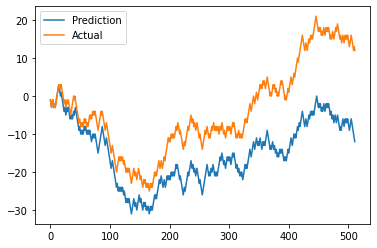

Epoch 1/20
258/258 - 8s - loss: 0.0305 - false_positives: 410.0000 - accuracy: 0.9933 - auc: 0.9985

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
258/258 - 3s - loss: 0.0183 - false_positives: 334.0000 - accuracy: 0.9950 - auc: 0.9993

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
258/258 - 3s - loss: 0.0143 - false_positives: 290.0000 - accuracy: 0.9954 - auc: 0.9996

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
258/258 - 3s - loss: 0.0192 - false_positives: 422.0000 - accuracy: 0.9936 - auc: 0.9995

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
258/258 - 3s - loss: 0.0155 - false_positives: 326.0000 - accuracy: 0.9950 - auc: 0.9996

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

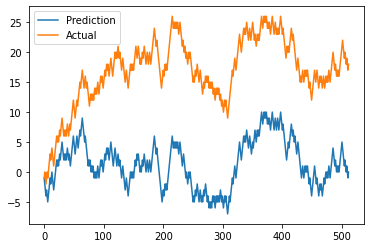

Epoch 1/20
259/259 - 8s - loss: 0.0271 - false_positives: 383.0000 - accuracy: 0.9938 - auc: 0.9987

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
259/259 - 3s - loss: 0.0166 - false_positives: 300.0000 - accuracy: 0.9952 - auc: 0.9995

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
259/259 - 3s - loss: 0.0134 - false_positives: 276.0000 - accuracy: 0.9956 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
259/259 - 3s - loss: 0.0159 - false_positives: 343.0000 - accuracy: 0.9948 - auc: 0.9996

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
259/259 - 3s - loss: 0.0150 - false_positives: 320.0000 - accuracy: 0.9950 - auc: 0.9996

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

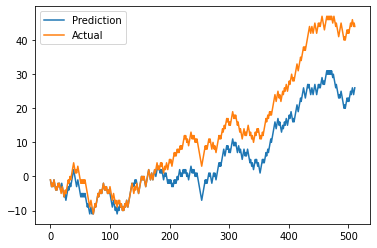

Epoch 1/20
260/260 - 8s - loss: 0.0261 - false_positives: 424.0000 - accuracy: 0.9935 - auc: 0.9988

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
260/260 - 3s - loss: 0.0146 - false_positives: 299.0000 - accuracy: 0.9955 - auc: 0.9996

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
260/260 - 3s - loss: 0.0124 - false_positives: 268.0000 - accuracy: 0.9960 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
260/260 - 3s - loss: 0.0156 - false_positives: 338.0000 - accuracy: 0.9949 - auc: 0.9995

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
260/260 - 3s - loss: 0.0144 - false_positives: 311.0000 - accuracy: 0.9954 - auc: 0.9997

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

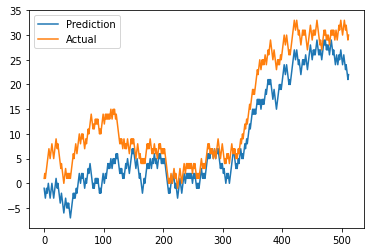

Epoch 1/20
261/261 - 8s - loss: 0.0227 - false_positives: 354.0000 - accuracy: 0.9946 - auc: 0.9989

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
261/261 - 3s - loss: 0.0161 - false_positives: 288.0000 - accuracy: 0.9956 - auc: 0.9994

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
261/261 - 3s - loss: 0.0123 - false_positives: 254.0000 - accuracy: 0.9961 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
261/261 - 3s - loss: 0.0137 - false_positives: 300.0000 - accuracy: 0.9955 - auc: 0.9997

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
261/261 - 3s - loss: 0.0138 - false_positives: 285.0000 - accuracy: 0.9956 - auc: 0.9996

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

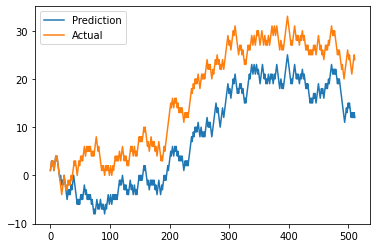

Epoch 1/20
262/262 - 8s - loss: 0.0212 - false_positives: 324.0000 - accuracy: 0.9949 - auc: 0.9991

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
262/262 - 3s - loss: 0.0150 - false_positives: 309.0000 - accuracy: 0.9958 - auc: 0.9994

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
262/262 - 3s - loss: 0.0126 - false_positives: 278.0000 - accuracy: 0.9959 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
262/262 - 3s - loss: 0.0133 - false_positives: 284.0000 - accuracy: 0.9956 - auc: 0.9997

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
262/262 - 3s - loss: 0.0132 - false_positives: 292.0000 - accuracy: 0.9956 - auc: 0.9997

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

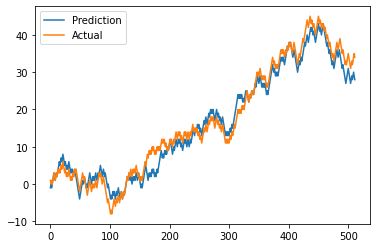

Epoch 1/20
263/263 - 8s - loss: 0.0219 - false_positives: 348.0000 - accuracy: 0.9948 - auc: 0.9991

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
263/263 - 3s - loss: 0.0167 - false_positives: 303.0000 - accuracy: 0.9956 - auc: 0.9993

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
263/263 - 3s - loss: 0.0120 - false_positives: 278.0000 - accuracy: 0.9960 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
263/263 - 3s - loss: 0.0104 - false_positives: 233.0000 - accuracy: 0.9964 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
263/263 - 3s - loss: 0.0122 - false_positives: 272.0000 - accuracy: 0.9960 - auc: 0.9997

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

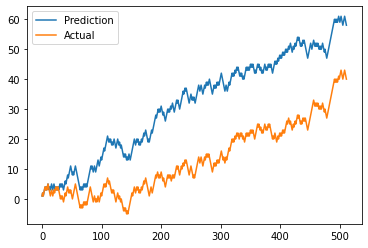

Epoch 1/20
264/264 - 8s - loss: 0.0179 - false_positives: 265.0000 - accuracy: 0.9959 - auc: 0.9993

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
264/264 - 3s - loss: 0.0130 - false_positives: 250.0000 - accuracy: 0.9961 - auc: 0.9996

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
264/264 - 3s - loss: 0.0100 - false_positives: 236.0000 - accuracy: 0.9965 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
264/264 - 3s - loss: 0.0156 - false_positives: 357.0000 - accuracy: 0.9946 - auc: 0.9996

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
264/264 - 3s - loss: 0.0120 - false_positives: 256.0000 - accuracy: 0.9961 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

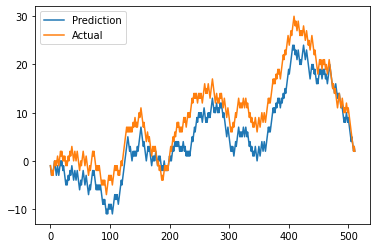

Epoch 1/20
265/265 - 8s - loss: 0.0167 - false_positives: 304.0000 - accuracy: 0.9956 - auc: 0.9993

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
265/265 - 3s - loss: 0.0134 - false_positives: 277.0000 - accuracy: 0.9959 - auc: 0.9996

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
265/265 - 3s - loss: 0.0106 - false_positives: 233.0000 - accuracy: 0.9966 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
265/265 - 3s - loss: 0.0114 - false_positives: 248.0000 - accuracy: 0.9963 - auc: 0.9997

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
265/265 - 3s - loss: 0.0104 - false_positives: 219.0000 - accuracy: 0.9967 - auc: 0.9997

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

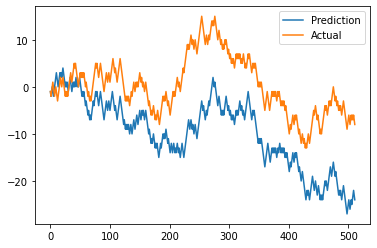

Epoch 1/20
266/266 - 8s - loss: 0.0201 - false_positives: 350.0000 - accuracy: 0.9950 - auc: 0.9992

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
266/266 - 3s - loss: 0.0124 - false_positives: 246.0000 - accuracy: 0.9964 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
266/266 - 3s - loss: 0.0105 - false_positives: 223.0000 - accuracy: 0.9968 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
266/266 - 3s - loss: 0.0103 - false_positives: 228.0000 - accuracy: 0.9967 - auc: 0.9997

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
266/266 - 3s - loss: 0.0126 - false_positives: 273.0000 - accuracy: 0.9959 - auc: 0.9997

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

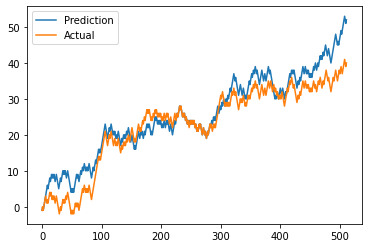

Epoch 1/20
267/267 - 8s - loss: 0.0181 - false_positives: 270.0000 - accuracy: 0.9960 - auc: 0.9992

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
267/267 - 3s - loss: 0.0134 - false_positives: 261.0000 - accuracy: 0.9962 - auc: 0.9996

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
267/267 - 3s - loss: 0.0101 - false_positives: 205.0000 - accuracy: 0.9969 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
267/267 - 3s - loss: 0.0103 - false_positives: 211.0000 - accuracy: 0.9967 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
267/267 - 3s - loss: 0.0101 - false_positives: 221.0000 - accuracy: 0.9967 - auc: 0.9997

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

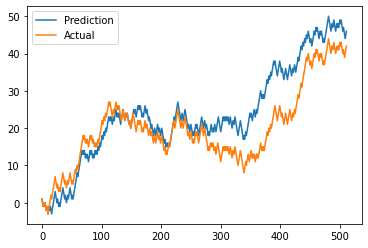

Epoch 1/20
268/268 - 8s - loss: 0.0156 - false_positives: 285.0000 - accuracy: 0.9959 - auc: 0.9993

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
268/268 - 3s - loss: 0.0135 - false_positives: 278.0000 - accuracy: 0.9961 - auc: 0.9995

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
268/268 - 3s - loss: 0.0082 - false_positives: 177.0000 - accuracy: 0.9974 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
268/268 - 3s - loss: 0.0089 - false_positives: 197.0000 - accuracy: 0.9971 - auc: 0.9997

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
268/268 - 3s - loss: 0.0122 - false_positives: 264.0000 - accuracy: 0.9960 - auc: 0.9997

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

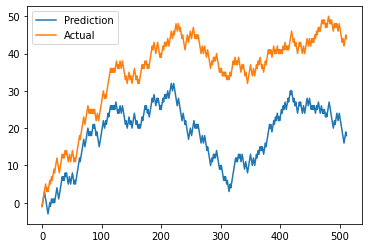

Epoch 1/20
269/269 - 8s - loss: 0.0151 - false_positives: 239.0000 - accuracy: 0.9962 - auc: 0.9993

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
269/269 - 3s - loss: 0.0119 - false_positives: 244.0000 - accuracy: 0.9964 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
269/269 - 3s - loss: 0.0077 - false_positives: 151.0000 - accuracy: 0.9976 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
269/269 - 3s - loss: 0.0110 - false_positives: 263.0000 - accuracy: 0.9963 - auc: 0.9997

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
269/269 - 3s - loss: 0.0106 - false_positives: 237.0000 - accuracy: 0.9966 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

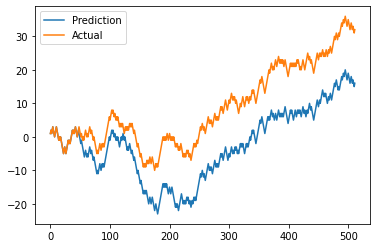

Epoch 1/20
270/270 - 8s - loss: 0.0163 - false_positives: 280.0000 - accuracy: 0.9959 - auc: 0.9993

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
270/270 - 3s - loss: 0.0114 - false_positives: 230.0000 - accuracy: 0.9967 - auc: 0.9996

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
270/270 - 3s - loss: 0.0078 - false_positives: 171.0000 - accuracy: 0.9975 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
270/270 - 3s - loss: 0.0100 - false_positives: 232.0000 - accuracy: 0.9966 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
270/270 - 3s - loss: 0.0091 - false_positives: 212.0000 - accuracy: 0.9970 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

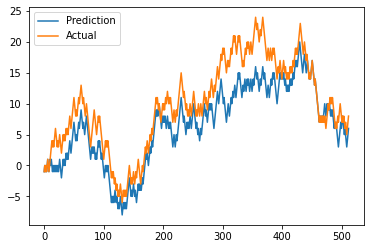

Epoch 1/20
271/271 - 8s - loss: 0.0153 - false_positives: 262.0000 - accuracy: 0.9963 - auc: 0.9994

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
271/271 - 3s - loss: 0.0117 - false_positives: 225.0000 - accuracy: 0.9969 - auc: 0.9996

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
271/271 - 3s - loss: 0.0083 - false_positives: 184.0000 - accuracy: 0.9974 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
271/271 - 3s - loss: 0.0089 - false_positives: 187.0000 - accuracy: 0.9972 - auc: 0.9997

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
271/271 - 3s - loss: 0.0106 - false_positives: 252.0000 - accuracy: 0.9964 - auc: 0.9997

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

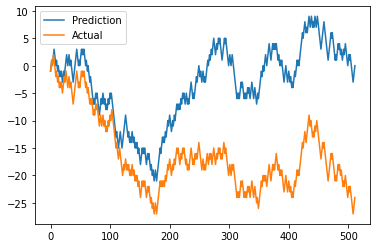

Epoch 1/20
272/272 - 8s - loss: 0.0128 - false_positives: 223.0000 - accuracy: 0.9968 - auc: 0.9995

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
272/272 - 3s - loss: 0.0101 - false_positives: 211.0000 - accuracy: 0.9970 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
272/272 - 3s - loss: 0.0098 - false_positives: 224.0000 - accuracy: 0.9968 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
272/272 - 3s - loss: 0.0090 - false_positives: 202.0000 - accuracy: 0.9971 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
272/272 - 3s - loss: 0.0087 - false_positives: 200.0000 - accuracy: 0.9972 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

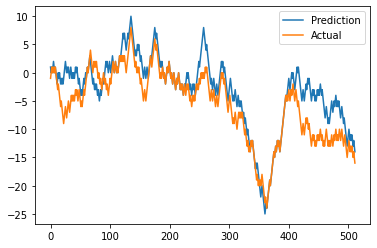

Epoch 1/20
273/273 - 8s - loss: 0.0153 - false_positives: 234.0000 - accuracy: 0.9967 - auc: 0.9993

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
273/273 - 3s - loss: 0.0081 - false_positives: 161.0000 - accuracy: 0.9978 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
273/273 - 3s - loss: 0.0090 - false_positives: 201.0000 - accuracy: 0.9971 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
273/273 - 3s - loss: 0.0102 - false_positives: 232.0000 - accuracy: 0.9966 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
273/273 - 3s - loss: 0.0091 - false_positives: 210.0000 - accuracy: 0.9971 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

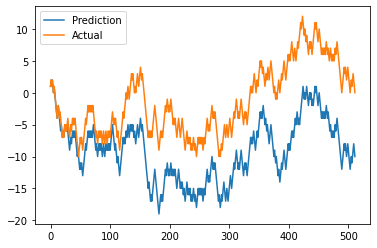

Epoch 1/20
274/274 - 8s - loss: 0.0115 - false_positives: 190.0000 - accuracy: 0.9972 - auc: 0.9995

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
274/274 - 3s - loss: 0.0112 - false_positives: 212.0000 - accuracy: 0.9968 - auc: 0.9996

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
274/274 - 3s - loss: 0.0079 - false_positives: 167.0000 - accuracy: 0.9975 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
274/274 - 3s - loss: 0.0074 - false_positives: 172.0000 - accuracy: 0.9975 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
274/274 - 3s - loss: 0.0084 - false_positives: 195.0000 - accuracy: 0.9972 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

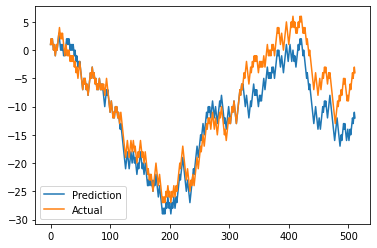

Epoch 1/20
275/275 - 8s - loss: 0.0117 - false_positives: 223.0000 - accuracy: 0.9968 - auc: 0.9995

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
275/275 - 3s - loss: 0.0095 - false_positives: 196.0000 - accuracy: 0.9972 - auc: 0.9996

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
275/275 - 3s - loss: 0.0073 - false_positives: 161.0000 - accuracy: 0.9977 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
275/275 - 3s - loss: 0.0088 - false_positives: 189.0000 - accuracy: 0.9972 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
275/275 - 3s - loss: 0.0085 - false_positives: 183.0000 - accuracy: 0.9973 - auc: 0.9997

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

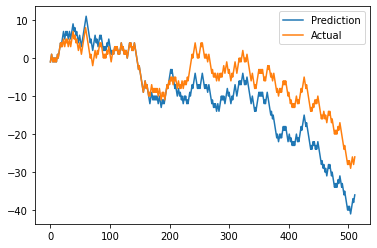

Epoch 1/20
276/276 - 8s - loss: 0.0110 - false_positives: 208.0000 - accuracy: 0.9969 - auc: 0.9996

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
276/276 - 3s - loss: 0.0093 - false_positives: 198.0000 - accuracy: 0.9972 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
276/276 - 3s - loss: 0.0062 - false_positives: 133.0000 - accuracy: 0.9981 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
276/276 - 3s - loss: 0.0074 - false_positives: 161.0000 - accuracy: 0.9977 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
276/276 - 3s - loss: 0.0090 - false_positives: 211.0000 - accuracy: 0.9970 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

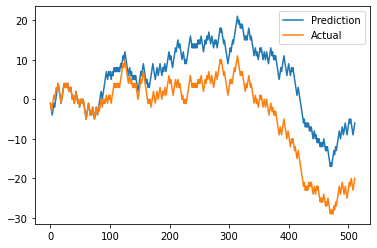

Epoch 1/20
277/277 - 8s - loss: 0.0106 - false_positives: 206.0000 - accuracy: 0.9970 - auc: 0.9995

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
277/277 - 3s - loss: 0.0085 - false_positives: 161.0000 - accuracy: 0.9976 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
277/277 - 3s - loss: 0.0062 - false_positives: 137.0000 - accuracy: 0.9980 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
277/277 - 3s - loss: 0.0087 - false_positives: 198.0000 - accuracy: 0.9971 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
277/277 - 3s - loss: 0.0086 - false_positives: 194.0000 - accuracy: 0.9972 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

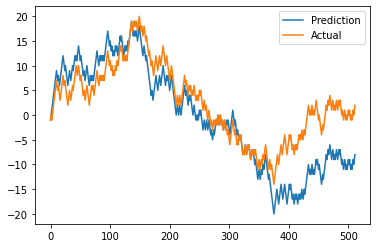

Epoch 1/20
278/278 - 8s - loss: 0.0107 - false_positives: 184.0000 - accuracy: 0.9973 - auc: 0.9996

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
278/278 - 3s - loss: 0.0088 - false_positives: 200.0000 - accuracy: 0.9973 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
278/278 - 3s - loss: 0.0077 - false_positives: 175.0000 - accuracy: 0.9976 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
278/278 - 3s - loss: 0.0088 - false_positives: 199.0000 - accuracy: 0.9973 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
278/278 - 3s - loss: 0.0077 - false_positives: 175.0000 - accuracy: 0.9976 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

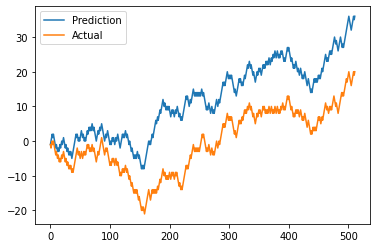

Epoch 1/20
279/279 - 8s - loss: 0.0114 - false_positives: 195.0000 - accuracy: 0.9972 - auc: 0.9996

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
279/279 - 3s - loss: 0.0074 - false_positives: 150.0000 - accuracy: 0.9979 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
279/279 - 3s - loss: 0.0094 - false_positives: 243.0000 - accuracy: 0.9969 - auc: 0.9997

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
279/279 - 3s - loss: 0.0062 - false_positives: 144.0000 - accuracy: 0.9980 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
279/279 - 3s - loss: 0.0081 - false_positives: 205.0000 - accuracy: 0.9973 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

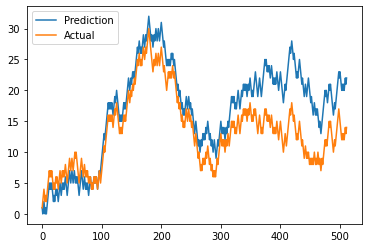

Epoch 1/20
280/280 - 8s - loss: 0.0092 - false_positives: 172.0000 - accuracy: 0.9977 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
280/280 - 3s - loss: 0.0083 - false_positives: 180.0000 - accuracy: 0.9976 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
280/280 - 3s - loss: 0.0067 - false_positives: 158.0000 - accuracy: 0.9977 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
280/280 - 3s - loss: 0.0086 - false_positives: 209.0000 - accuracy: 0.9972 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
280/280 - 3s - loss: 0.0071 - false_positives: 168.0000 - accuracy: 0.9977 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

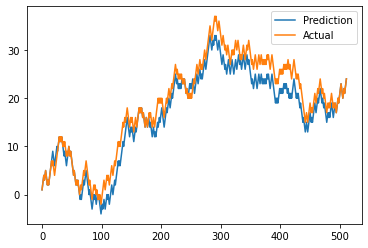

Epoch 1/20
281/281 - 8s - loss: 0.0110 - false_positives: 204.0000 - accuracy: 0.9971 - auc: 0.9996

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
281/281 - 3s - loss: 0.0081 - false_positives: 181.0000 - accuracy: 0.9975 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
281/281 - 3s - loss: 0.0053 - false_positives: 118.0000 - accuracy: 0.9984 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
281/281 - 3s - loss: 0.0059 - false_positives: 120.0000 - accuracy: 0.9981 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
281/281 - 3s - loss: 0.0082 - false_positives: 194.0000 - accuracy: 0.9973 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

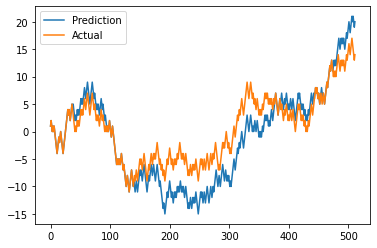

Epoch 1/20
282/282 - 8s - loss: 0.0090 - false_positives: 171.0000 - accuracy: 0.9976 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
282/282 - 3s - loss: 0.0076 - false_positives: 150.0000 - accuracy: 0.9979 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
282/282 - 3s - loss: 0.0075 - false_positives: 172.0000 - accuracy: 0.9976 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
282/282 - 3s - loss: 0.0082 - false_positives: 197.0000 - accuracy: 0.9973 - auc: 0.9997

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
282/282 - 3s - loss: 0.0059 - false_positives: 141.0000 - accuracy: 0.9980 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

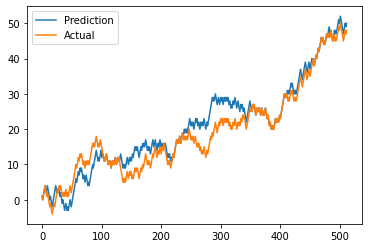

Epoch 1/20
283/283 - 8s - loss: 0.0114 - false_positives: 181.0000 - accuracy: 0.9975 - auc: 0.9996

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
283/283 - 3s - loss: 0.0083 - false_positives: 155.0000 - accuracy: 0.9979 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
283/283 - 3s - loss: 0.0061 - false_positives: 140.0000 - accuracy: 0.9981 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
283/283 - 3s - loss: 0.0064 - false_positives: 144.0000 - accuracy: 0.9979 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
283/283 - 3s - loss: 0.0066 - false_positives: 158.0000 - accuracy: 0.9979 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

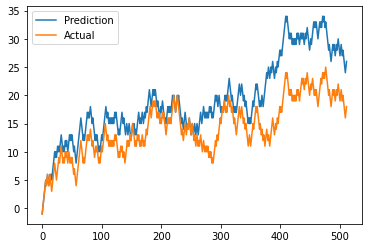

Epoch 1/20
284/284 - 9s - loss: 0.0096 - false_positives: 175.0000 - accuracy: 0.9976 - auc: 0.9996

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
284/284 - 3s - loss: 0.0079 - false_positives: 171.0000 - accuracy: 0.9977 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
284/284 - 3s - loss: 0.0075 - false_positives: 177.0000 - accuracy: 0.9977 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
284/284 - 3s - loss: 0.0054 - false_positives: 131.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
284/284 - 3s - loss: 0.0054 - false_positives: 133.0000 - accuracy: 0.9984 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

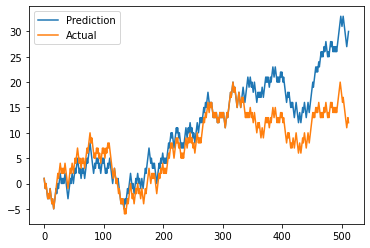

Epoch 1/20
285/285 - 8s - loss: 0.0095 - false_positives: 186.0000 - accuracy: 0.9976 - auc: 0.9996

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
285/285 - 3s - loss: 0.0072 - false_positives: 158.0000 - accuracy: 0.9978 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
285/285 - 3s - loss: 0.0062 - false_positives: 147.0000 - accuracy: 0.9980 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
285/285 - 3s - loss: 0.0061 - false_positives: 141.0000 - accuracy: 0.9981 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
285/285 - 3s - loss: 0.0070 - false_positives: 175.0000 - accuracy: 0.9976 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

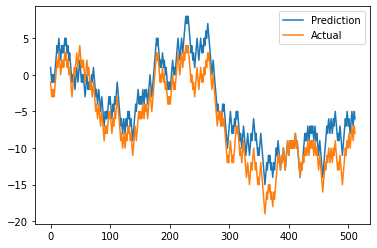

Epoch 1/20
286/286 - 8s - loss: 0.0085 - false_positives: 159.0000 - accuracy: 0.9976 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
286/286 - 3s - loss: 0.0074 - false_positives: 155.0000 - accuracy: 0.9978 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
286/286 - 3s - loss: 0.0054 - false_positives: 125.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
286/286 - 3s - loss: 0.0059 - false_positives: 149.0000 - accuracy: 0.9980 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
286/286 - 3s - loss: 0.0069 - false_positives: 167.0000 - accuracy: 0.9977 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

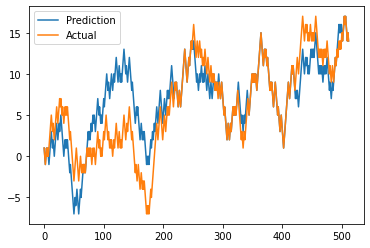

Epoch 1/20
287/287 - 9s - loss: 0.0094 - false_positives: 163.0000 - accuracy: 0.9978 - auc: 0.9996

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
287/287 - 3s - loss: 0.0076 - false_positives: 168.0000 - accuracy: 0.9978 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
287/287 - 3s - loss: 0.0066 - false_positives: 159.0000 - accuracy: 0.9979 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
287/287 - 3s - loss: 0.0048 - false_positives: 111.0000 - accuracy: 0.9985 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
287/287 - 3s - loss: 0.0071 - false_positives: 171.0000 - accuracy: 0.9976 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

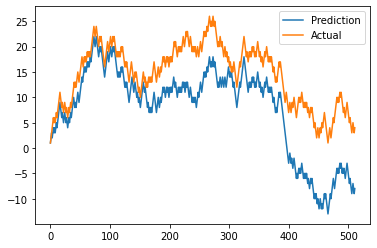

Epoch 1/20
288/288 - 8s - loss: 0.0085 - false_positives: 159.0000 - accuracy: 0.9978 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
288/288 - 3s - loss: 0.0081 - false_positives: 180.0000 - accuracy: 0.9978 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
288/288 - 3s - loss: 0.0037 - false_positives: 89.0000 - accuracy: 0.9988 - auc: 1.0000

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
288/288 - 3s - loss: 0.0067 - false_positives: 156.0000 - accuracy: 0.9980 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
288/288 - 3s - loss: 0.0070 - false_positives: 180.0000 - accuracy: 0.9976 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Research

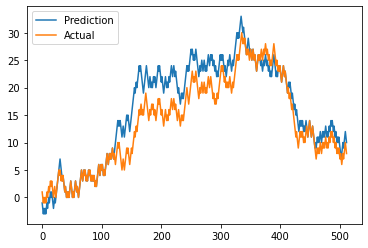

Epoch 1/20
289/289 - 8s - loss: 0.0089 - false_positives: 153.0000 - accuracy: 0.9979 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
289/289 - 3s - loss: 0.0077 - false_positives: 176.0000 - accuracy: 0.9976 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
289/289 - 3s - loss: 0.0046 - false_positives: 97.0000 - accuracy: 0.9987 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
289/289 - 3s - loss: 0.0065 - false_positives: 163.0000 - accuracy: 0.9979 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
289/289 - 3s - loss: 0.0051 - false_positives: 124.0000 - accuracy: 0.9984 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Research

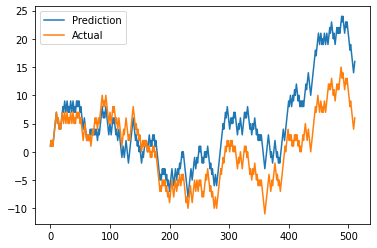

Epoch 1/20
290/290 - 9s - loss: 0.0085 - false_positives: 176.0000 - accuracy: 0.9977 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
290/290 - 3s - loss: 0.0077 - false_positives: 156.0000 - accuracy: 0.9980 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
290/290 - 3s - loss: 0.0055 - false_positives: 136.0000 - accuracy: 0.9981 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
290/290 - 3s - loss: 0.0038 - false_positives: 97.0000 - accuracy: 0.9988 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
290/290 - 3s - loss: 0.0063 - false_positives: 154.0000 - accuracy: 0.9979 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Research

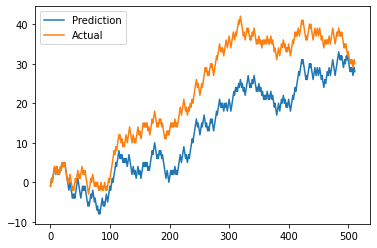

Epoch 1/20
291/291 - 9s - loss: 0.0109 - false_positives: 166.0000 - accuracy: 0.9979 - auc: 0.9995

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
291/291 - 3s - loss: 0.0073 - false_positives: 162.0000 - accuracy: 0.9978 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
291/291 - 3s - loss: 0.0047 - false_positives: 117.0000 - accuracy: 0.9985 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
291/291 - 3s - loss: 0.0056 - false_positives: 132.0000 - accuracy: 0.9982 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
291/291 - 3s - loss: 0.0060 - false_positives: 139.0000 - accuracy: 0.9981 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

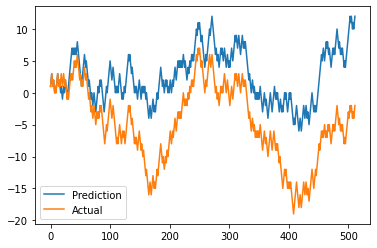

Epoch 1/20
292/292 - 9s - loss: 0.0083 - false_positives: 145.0000 - accuracy: 0.9980 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
292/292 - 3s - loss: 0.0060 - false_positives: 128.0000 - accuracy: 0.9983 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
292/292 - 3s - loss: 0.0064 - false_positives: 149.0000 - accuracy: 0.9980 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
292/292 - 3s - loss: 0.0060 - false_positives: 151.0000 - accuracy: 0.9980 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
292/292 - 3s - loss: 0.0058 - false_positives: 122.0000 - accuracy: 0.9982 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

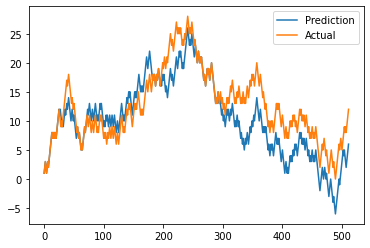

Epoch 1/20
293/293 - 9s - loss: 0.0084 - false_positives: 162.0000 - accuracy: 0.9980 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
293/293 - 3s - loss: 0.0063 - false_positives: 135.0000 - accuracy: 0.9981 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
293/293 - 3s - loss: 0.0060 - false_positives: 137.0000 - accuracy: 0.9981 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
293/293 - 3s - loss: 0.0060 - false_positives: 140.0000 - accuracy: 0.9981 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
293/293 - 3s - loss: 0.0059 - false_positives: 142.0000 - accuracy: 0.9981 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

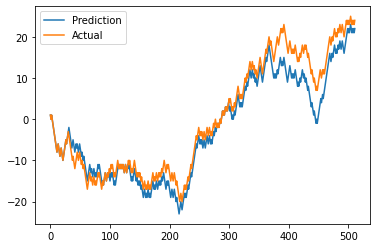

Epoch 1/20
294/294 - 9s - loss: 0.0080 - false_positives: 145.0000 - accuracy: 0.9980 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
294/294 - 3s - loss: 0.0077 - false_positives: 166.0000 - accuracy: 0.9978 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
294/294 - 3s - loss: 0.0043 - false_positives: 93.0000 - accuracy: 0.9987 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
294/294 - 3s - loss: 0.0064 - false_positives: 157.0000 - accuracy: 0.9979 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
294/294 - 3s - loss: 0.0069 - false_positives: 174.0000 - accuracy: 0.9977 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Research

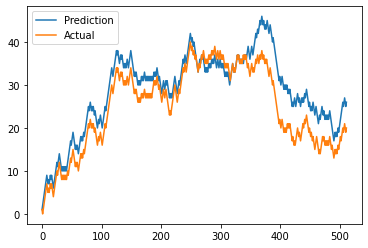

Epoch 1/20
295/295 - 9s - loss: 0.0088 - false_positives: 136.0000 - accuracy: 0.9980 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
295/295 - 3s - loss: 0.0064 - false_positives: 134.0000 - accuracy: 0.9982 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
295/295 - 3s - loss: 0.0048 - false_positives: 98.0000 - accuracy: 0.9987 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
295/295 - 3s - loss: 0.0058 - false_positives: 144.0000 - accuracy: 0.9981 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
295/295 - 3s - loss: 0.0054 - false_positives: 123.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Research

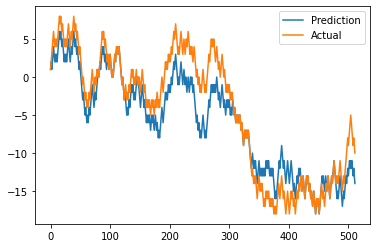

Epoch 1/20
296/296 - 9s - loss: 0.0073 - false_positives: 137.0000 - accuracy: 0.9983 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
296/296 - 3s - loss: 0.0066 - false_positives: 154.0000 - accuracy: 0.9980 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
296/296 - 3s - loss: 0.0054 - false_positives: 141.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
296/296 - 3s - loss: 0.0056 - false_positives: 139.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
296/296 - 3s - loss: 0.0061 - false_positives: 155.0000 - accuracy: 0.9979 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

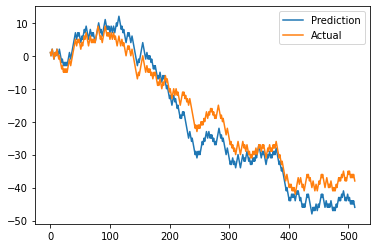

Epoch 1/20
297/297 - 9s - loss: 0.0084 - false_positives: 160.0000 - accuracy: 0.9979 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
297/297 - 3s - loss: 0.0064 - false_positives: 139.0000 - accuracy: 0.9982 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
297/297 - 3s - loss: 0.0044 - false_positives: 98.0000 - accuracy: 0.9987 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
297/297 - 3s - loss: 0.0060 - false_positives: 144.0000 - accuracy: 0.9981 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
297/297 - 3s - loss: 0.0059 - false_positives: 138.0000 - accuracy: 0.9981 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Research

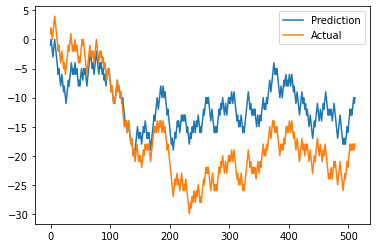

Epoch 1/20
298/298 - 9s - loss: 0.0080 - false_positives: 130.0000 - accuracy: 0.9983 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
298/298 - 3s - loss: 0.0057 - false_positives: 122.0000 - accuracy: 0.9984 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
298/298 - 3s - loss: 0.0046 - false_positives: 117.0000 - accuracy: 0.9986 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
298/298 - 3s - loss: 0.0052 - false_positives: 130.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
298/298 - 3s - loss: 0.0062 - false_positives: 148.0000 - accuracy: 0.9980 - auc: 0.9998

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

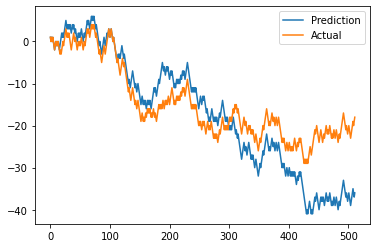

Epoch 1/20
299/299 - 9s - loss: 0.0093 - false_positives: 151.0000 - accuracy: 0.9980 - auc: 0.9996

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
299/299 - 3s - loss: 0.0061 - false_positives: 129.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
299/299 - 3s - loss: 0.0044 - false_positives: 107.0000 - accuracy: 0.9986 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
299/299 - 3s - loss: 0.0050 - false_positives: 110.0000 - accuracy: 0.9984 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
299/299 - 3s - loss: 0.0051 - false_positives: 127.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

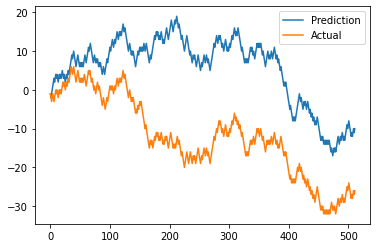

Epoch 1/20
300/300 - 9s - loss: 0.0080 - false_positives: 148.0000 - accuracy: 0.9981 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
300/300 - 3s - loss: 0.0072 - false_positives: 129.0000 - accuracy: 0.9982 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
300/300 - 3s - loss: 0.0042 - false_positives: 107.0000 - accuracy: 0.9987 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
300/300 - 3s - loss: 0.0060 - false_positives: 152.0000 - accuracy: 0.9981 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
300/300 - 3s - loss: 0.0055 - false_positives: 133.0000 - accuracy: 0.9982 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

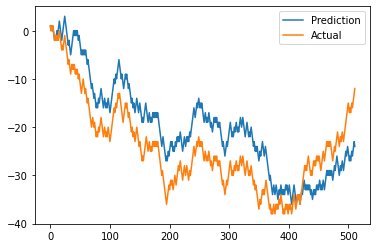

Epoch 1/20
301/301 - 9s - loss: 0.0082 - false_positives: 122.0000 - accuracy: 0.9983 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
301/301 - 3s - loss: 0.0067 - false_positives: 167.0000 - accuracy: 0.9980 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
301/301 - 3s - loss: 0.0054 - false_positives: 127.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
301/301 - 3s - loss: 0.0050 - false_positives: 116.0000 - accuracy: 0.9985 - auc: 0.9998

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
301/301 - 3s - loss: 0.0045 - false_positives: 107.0000 - accuracy: 0.9985 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

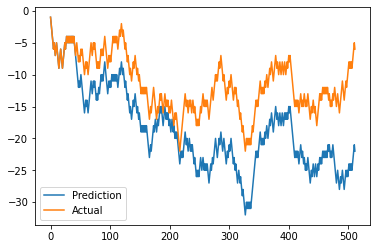

Epoch 1/20
302/302 - 9s - loss: 0.0088 - false_positives: 159.0000 - accuracy: 0.9980 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
302/302 - 3s - loss: 0.0062 - false_positives: 133.0000 - accuracy: 0.9984 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
302/302 - 3s - loss: 0.0053 - false_positives: 121.0000 - accuracy: 0.9985 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
302/302 - 3s - loss: 0.0051 - false_positives: 123.0000 - accuracy: 0.9984 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
302/302 - 3s - loss: 0.0040 - false_positives: 107.0000 - accuracy: 0.9986 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

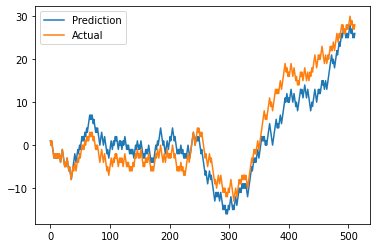

Epoch 1/20
303/303 - 9s - loss: 0.0062 - false_positives: 121.0000 - accuracy: 0.9984 - auc: 0.9998

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
303/303 - 3s - loss: 0.0059 - false_positives: 148.0000 - accuracy: 0.9982 - auc: 0.9999

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
303/303 - 3s - loss: 0.0061 - false_positives: 125.0000 - accuracy: 0.9982 - auc: 0.9998

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
303/303 - 3s - loss: 0.0043 - false_positives: 111.0000 - accuracy: 0.9985 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
303/303 - 3s - loss: 0.0051 - false_positives: 130.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

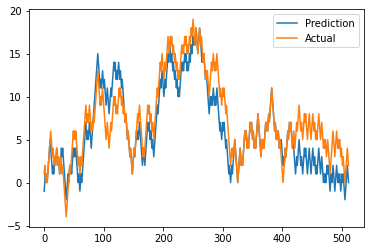

Epoch 1/20
304/304 - 9s - loss: 0.0072 - false_positives: 141.0000 - accuracy: 0.9984 - auc: 0.9997

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
304/304 - 3s - loss: 0.0072 - false_positives: 153.0000 - accuracy: 0.9980 - auc: 0.9997

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
304/304 - 3s - loss: 0.0044 - false_positives: 113.0000 - accuracy: 0.9986 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
304/304 - 3s - loss: 0.0057 - false_positives: 136.0000 - accuracy: 0.9982 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
304/304 - 3s - loss: 0.0057 - false_positives: 155.0000 - accuracy: 0.9981 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Researc

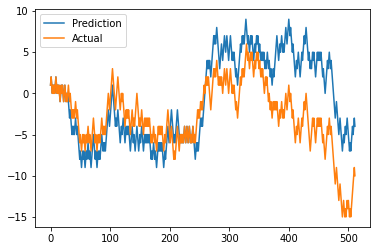

Epoch 1/20
305/305 - 9s - loss: 0.0059 - false_positives: 122.0000 - accuracy: 0.9985 - auc: 0.9998

Epoch 00001: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 2/20
305/305 - 3s - loss: 0.0061 - false_positives: 143.0000 - accuracy: 0.9982 - auc: 0.9998

Epoch 00002: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 3/20
305/305 - 3s - loss: 0.0050 - false_positives: 126.0000 - accuracy: 0.9984 - auc: 0.9999

Epoch 00003: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 4/20
305/305 - 3s - loss: 0.0041 - false_positives: 97.0000 - accuracy: 0.9988 - auc: 0.9999

Epoch 00004: saving model to /content/drive/My Drive/Stock Price Prediction Research/weights.best.hdf5
Epoch 5/20
305/305 - 3s - loss: 0.0052 - false_positives: 133.0000 - accuracy: 0.9983 - auc: 0.9999

Epoch 00005: saving model to /content/drive/My Drive/Stock Price Prediction Research

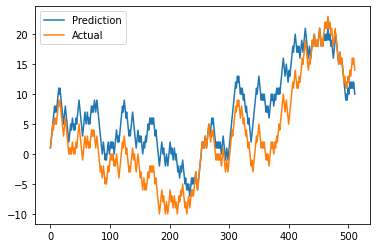

In [63]:

pred, fscore, actual = walk_forward(300,2**17, 2**9,20,50)


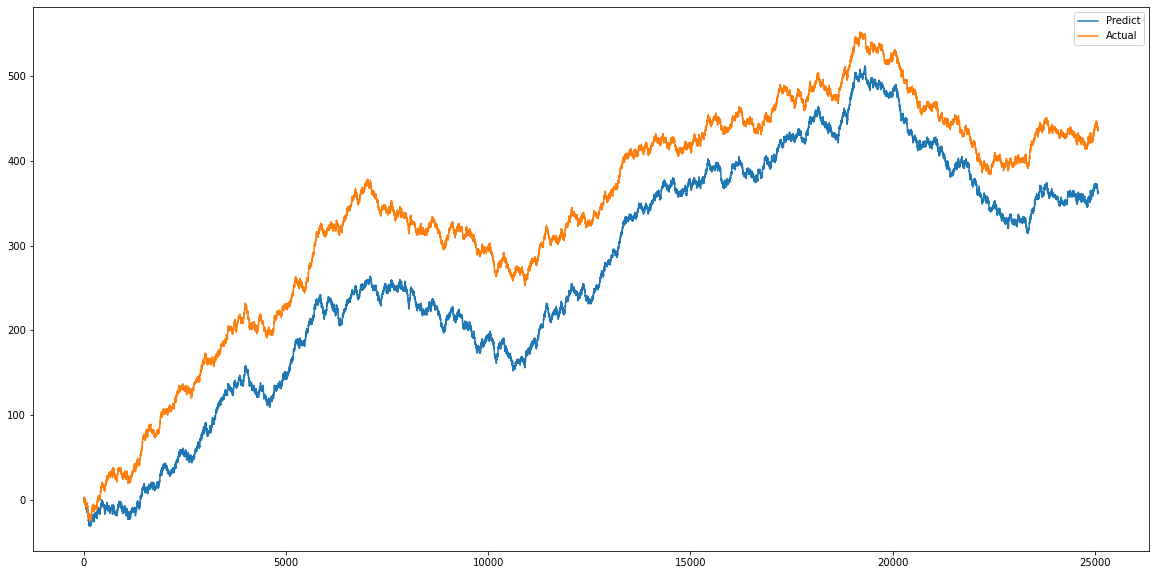

In [64]:
plot_prediction(actual, pred)

In [66]:
metrics.roc_auc_score(actual,pred)

0.9269812285417454

As we can see here, we have acheived an ROC-AUC score of 92.69% and the plot above shows the real price movement compared to the predicted pre